In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
import pandas as pd

plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

In [3]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40,
                 48.45, 52.34, 55.65, 51.49, 51.86, 63.43,
                 53.00, 56.09, 51.93, 52.31, 52.33, 57.48,
                 57.44, 55.14, 53.93, 54.62, 56.09, 68.58,
                 51.36, 55.47, 50.73, 51.94, 54.95, 50.39,
                 52.91, 51.50, 52.68, 47.72, 49.73, 51.82,
                 54.99, 52.84, 53.19, 54.52, 51.46, 53.73,
                 51.61, 49.81, 52.42, 54.30, 53.84, 53.16])

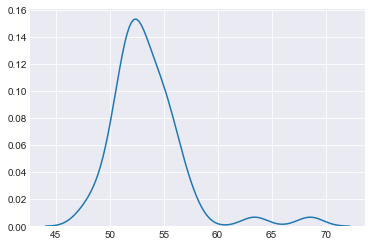

In [4]:
sns.kdeplot(data)

### 3.2 正規分布の平均と標準偏差の周辺分布とトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 1600/1600 [00:02<00:00, 764.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c184b28d0>,
      dtype=object)

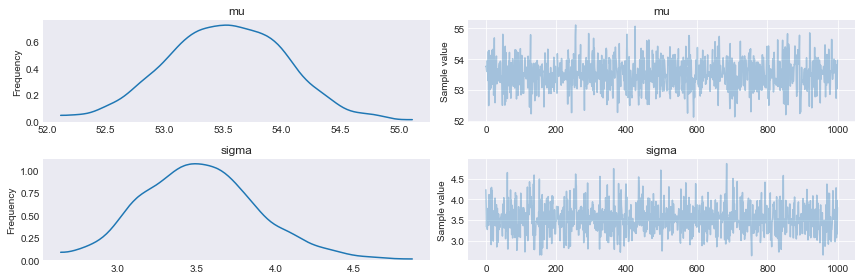

In [5]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace_g = pm.sample(1100, chains=1)

chain_g = trace_g[100:]
pm.traceplot(chain_g)

In [6]:
print(chain_g)

<MultiTrace: 1 chains, 1000 iterations, 4 variables>


In [7]:
df = pm.summary(chain_g)

In [8]:
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.52,0.51,0.01,52.50,54.43
sigma,3.52,0.37,0.01,2.73,4.17


### 3.3 データのKDEと100組みの事後予測サンプルのKDE（正規分布）を出力する

100%|██████████| 100/100 [00:00<00:00, 661.03it/s]


Text(0.5,0,'$x$')

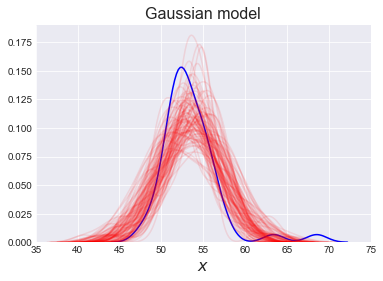

In [55]:
y_pred = pm.sample_ppc(chain_g, 100, model_g)
sns.kdeplot(data, color='b')
for i in y_pred['y']:
    sns.kdeplot(i, color='r', alpha=0.1)
plt.xlim(35, 75)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

### 3.4 Student t distributions

In [34]:
np.mean(stats.t(loc=0, scale=1, df=100).rvs(100))

0.027023525541160207

(-7, 7)

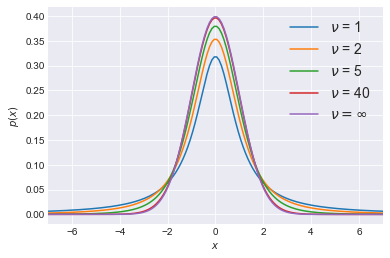

In [37]:
x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 40]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))
    
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7)

### 3.5 Student T distributionを含むモデルのKDEとトレースプロットを出力

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, sigma, mu]
100%|██████████| 1600/1600 [00:02<00:00, 575.84it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a2254e0>,
      dtype=object)

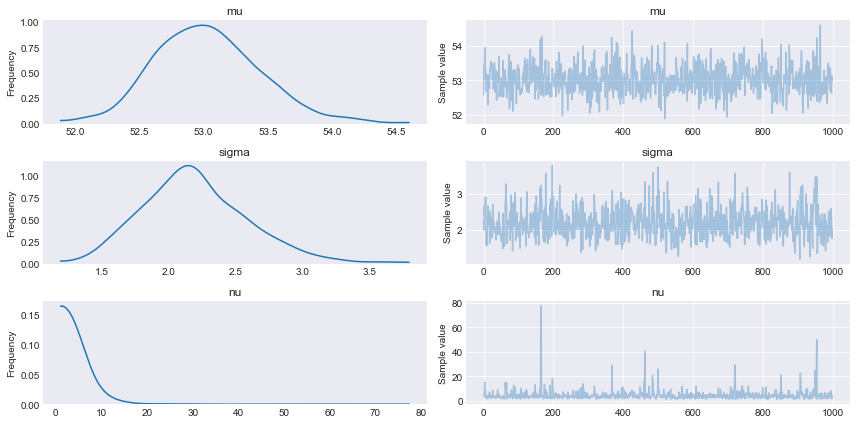

In [46]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_t = pm.sample(1100, chains=1)
    
chain_t = trace_t[100:]
pm.traceplot(chain_t)

In [47]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.02,0.41,0.01,52.30,53.85
sigma,2.20,0.40,0.02,1.47,2.99
nu,4.84,4.79,0.21,1.25,11.16


100%|██████████| 100/100 [00:00<00:00, 1046.68it/s]


Text(0.5,0,'$x$')

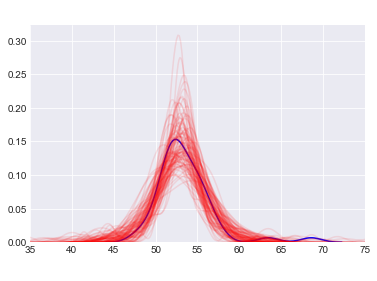

In [57]:
y_pred = pm.sample_ppc(chain_t, 100, model_t)
sns.kdeplot(data, color='b')
for i in y_pred['y']:
    sns.kdeplot(i, color='r', alpha=0.1)
plt.xlim(35, 75)
plt.title('Student"s model', fontsize=16, color='w')
plt.xlabel('$x$', fontsize=16, color='w')

## Tips Dataset

In [58]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


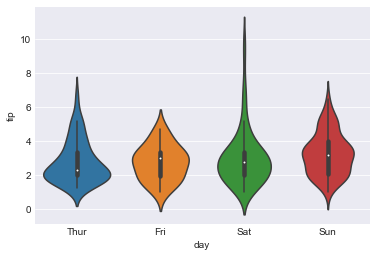

In [60]:
sns.violinplot(x='day', y='tip', data=tips)

In [61]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

### 3.9 Output the KDE and the traceplot of Tips Dataset

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sds, means]
100%|██████████| 5500/5500 [00:15<00:00, 344.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d4be320>,
      dtype=object)

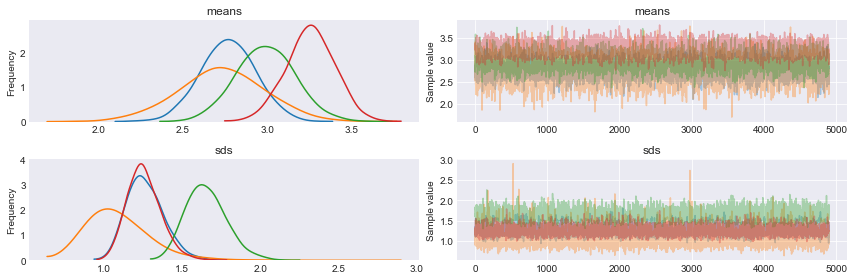

In [63]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))
    y=pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(5000, chains=1)
    
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

In [64]:
pm.summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,2.77,0.16,2.26e-03,2.45,3.08
means__1,2.73,0.26,3.77e-03,2.20,3.20
means__2,2.99,0.17,2.31e-03,2.63,3.32
means__3,3.26,0.14,1.89e-03,2.97,3.53
sds__0,1.27,0.12,1.43e-03,1.06,1.51
sds__1,1.09,0.20,3.00e-03,0.73,1.46
sds__2,1.65,0.13,2.16e-03,1.41,1.91
sds__3,1.26,0.11,1.57e-03,1.06,1.47


### 3.10 Reference Value 0 and HPD of the tip difference between days

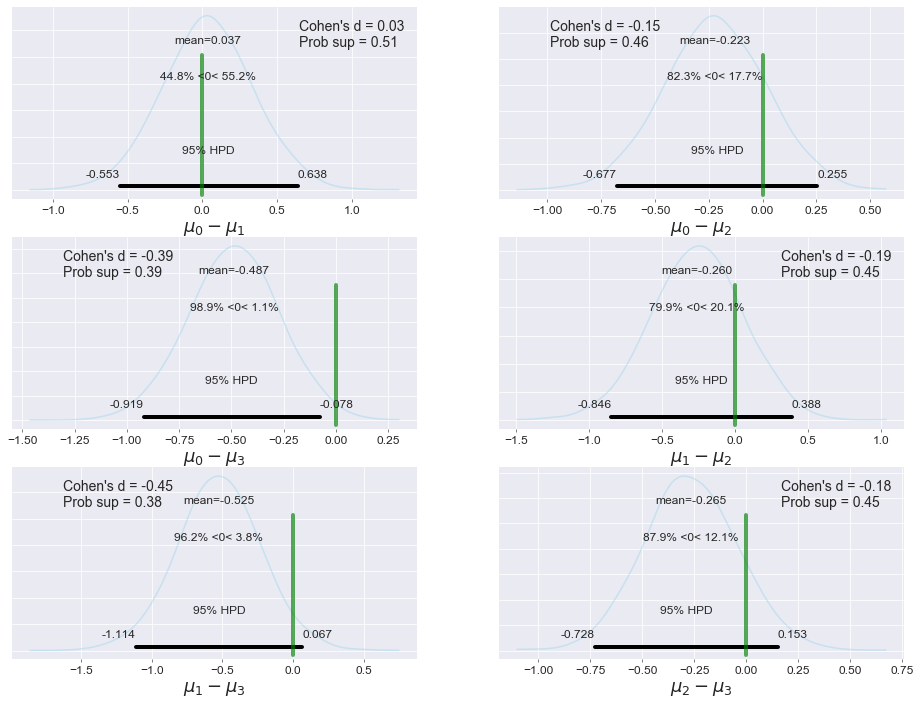

In [72]:
dist = stats.norm()
_, ax= plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l)for k in range(3) for l in (0, 1)]

for (i,j), (k,l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i] - chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen / (2**0.5))
    
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k,l], color='skyblue', kde_plot=True)
    ax[k,l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k,l].legend(loc=0, fontsize=14)